<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8_S5_Batch_Normalization_-_Regularization/blob/main/EVA8_Session_5_Batch_Normalization_%26_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount Google Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
!cp /content/drive/MyDrive/mymodel.py .


In [21]:
import mymodel
model = mymodel.Net()

# Import libraries

In [22]:
from torchvision import datasets, transforms
import torch
import torch.optim as optim

In [23]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function

# Find mean and std deviation of the data

In [24]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


In [25]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [26]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(255,))
                                      ])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [27]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [28]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  False


# View few images

torch.Size([64, 1, 28, 28])
torch.Size([64])


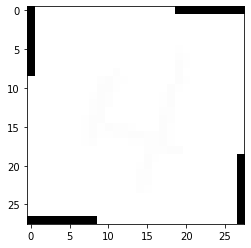

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)
#images, labels = next(dataiter)
#images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

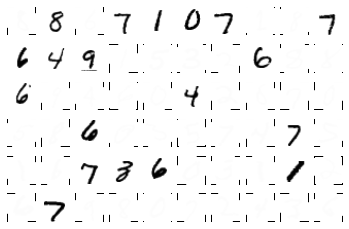

In [30]:
figure = plt.figure()
num_of_images=60
for index in range (1, num_of_images+1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



In [31]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


# Training and Testing - Group Normalization

In [32]:
from tqdm import tqdm

train_losses_group = []
test_losses_group = []
train_acc_group = []
test_acc_group = []
type_of_norm = 'gn'

def train(model, device, train_loader, optimizer, epoch):
  print("type_of_norm:", type_of_norm)
  model.train()
  print("type_of_norm2:", type_of_norm)
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_group.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_group.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_group.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_group.append(100. * correct / len(test_loader.dataset))

In [33]:
model = mymodel.Net()
#model = Net()

In [34]:
from tqdm import tqdm

train_losses_group = []
test_losses_group = []
train_acc_group = []
test_acc_group = []
type_of_norm = 'gn'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_group.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_group.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_group.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_group.append(100. * correct / len(test_loader.dataset))

# Train the model for Group Normalization


In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
#model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.20593038201332092 Batch_id=900 Accuracy=78.01:  96%|█████████▌| 900/938 [02:07<00:05,  7.49it/s]

# Training and Testing - Layer Normalization

In [ ]:
from tqdm import tqdm

train_losses_layer = []
test_losses_layer = []
train_acc_layer = []
test_acc_layer = []
type_of_norm = 'ln'

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses_layer.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_layer.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_layer.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_layer.append(100. * correct / len(test_loader.dataset))

# Train the model for Layer Normalization


In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

 # Training and Testing - Batch Normalization and L1 Regularization

In [ ]:
from tqdm import tqdm

train_losses_bn = []
test_losses_bn = []
train_acc_bn = []
test_acc_bn = []
type_of_norm = 'bn'

mse=nn.MSELoss()
lambda_l1 = 0.001

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data, type_of_norm)

    # Calculate loss
    target=target.float().unsqueeze(dim=1)

    loss = mse(y_pred, target)
    l1 = 0
    
    for p in model.parameters():
      l1 = l1 + p.abs().sum()
    loss = loss + lambda_l1 * l1
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_bn.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, type_of_norm)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_bn.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_bn.append(100. * correct / len(test_loader.dataset))

# Train the model for Batch Normalization and L1 Regularization

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  mymodel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

# Plot graphs

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_group, color='r', label='group norm')
axs[0, 0].plot(train_losses_layer, color='b', label='layer norm')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_group[4000:], color='r', label='group norm')
axs[1, 0].plot(train_acc_layer[4000:], color='b', label='layer norm')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_group, color='r', label='group norm')
axs[0, 1].plot(test_losses_layer, color='b', label='layer norm')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_group, color='r', label='group norm')
axs[1, 1].plot(test_acc_layer, color='b', label='layer norm')
axs[1, 1].set_title("Test Accuracy")
